# Figure 2b. Number of detectable and mappable xQTL loci in multi−context fine−mapping

## number of detectable and mappable xQTL loci in ROSMAP multi-context fine-mapping 
* prepare the input dataset for the bar plot using the ROSMAP exported multicontext top loci summary results
* We only consider three categories in the detectable and mappable: 1: 1-3 loci; 2: 4~10 loci; 3: >10 loci

In [19]:
library(data.table)
library(dplyr)
library(tidyr)
library(ggplot2)
library(RColorBrewer)
ROSMAP_multicontext_top_loci <- fread("/data/analysis_result/multi_context/ROSMAP/export/summary/ROSMAP.exported.toploci.bed.gz")
ROSMAP_multicontext_top_loci_pip_sum <- ROSMAP_multicontext_top_loci %>% group_by(gene_ID)%>% mutate(pip_sum = sum(PIP))
coverage <- "cs_coverage_0.95"
multicontext_top_loci_detectable_mappable_summary <- ROSMAP_multicontext_top_loci_pip_sum %>% group_by(gene_ID)%>%
                                                     filter(pip_sum >= 0.95)%>%
                                                     mutate(n_detectable = ifelse(all(.data[[coverage]] == 0), 0, n_distinct(.data[[coverage]][.data[[coverage]] != 0])))%>%
                                                     mutate(n_mappable = ifelse(n_detectable == 0, 0, NA)) %>%
                                                          left_join(
                                                                    ROSMAP_multicontext_top_loci_pip_sum %>%
                      
                                                              filter(.data[[coverage]] != 0) %>%  # Remove zero values
                                                                    group_by(gene_ID, .data[[coverage]]) %>%
                                                                    summarize(variant_count = n(), .groups = "drop") %>%
                                                                    group_by(gene_ID) %>%
                                                                    summarize(n_mappable = sum(variant_count <= 3), .groups = "drop"),
                                                                    by = "gene_ID"
                                                                    )%>%
                                                    mutate(n_mappable = coalesce(n_mappable.x, n_mappable.y))%>%
                                                    select(-c(n_mappable.x, n_mappable.y))
# Data preparation and summarization
multicontext_top_loci_bar_plot_input <- multicontext_top_loci_detectable_mappable_summary %>%
  group_by(gene_ID) %>% filter(pip_sum >=0.95) %>% ungroup() %>%
  select(gene_ID, n_detectable, n_mappable) %>% filter (n_detectable!=0)%>%
  unique() %>%
  mutate(
    n_detectable_category = case_when(
      n_detectable >= 1 & n_detectable <= 3 ~ "1",
      n_detectable >= 4 & n_detectable <= 10 ~ "2",
      n_detectable > 10 ~ "3"
    ),
    n_mappable_category = case_when(
      n_mappable >= 1 & n_mappable <= 3 ~ "1",
      n_mappable >= 4 & n_mappable <= 10 ~ "2",
      n_mappable > 10  ~ "3",
    )
  ) %>%
  pivot_longer(
    cols = c(n_detectable, n_mappable),
    names_to = "category_type",
    values_to = "count",
    names_prefix = "n_"
  ) %>%
  mutate(subcategory = if_else(category_type == "detectable", n_detectable_category, n_mappable_category),
         subcategory = factor(subcategory, levels = rev(c("1", "2", "3")))) %>%
  group_by(category_type, subcategory) %>%
  summarise(gene_count = n(), .groups = 'drop') %>%
  mutate(log_gene_count = log1p(gene_count))

In [20]:
multicontext_top_loci_bar_plot_input <- multicontext_top_loci_bar_plot_input %>% filter(!is.na(subcategory))
multicontext_top_loci_bar_plot_input$subcategory <- factor(multicontext_top_loci_bar_plot_input$subcategory,
                                                           levels = as.character(1:3))

# Assign two colors manually
bar_colors <- c("detectable" = "#66c2a5", "mappable" = "#fc8d62")
x_axis_labels <- c(
                   "1" = "1~3", 
                   "2" = "4~10", 
                   "3" = ">10"
                   )
resources    <- unique(multicontext_top_loci_bar_plot_input$subcategory)
pos_map      <- setNames(seq_along(resources), resources)
w            <- 0.25
# Plot
p1 <- ggplot(multicontext_top_loci_bar_plot_input,
       aes(x = subcategory, y = gene_count, fill = category_type)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.7) +
  geom_text(aes(label = gene_count),
            position = position_dodge(width = 0.6),
            vjust = -0.3, size = 5, fontface = "bold") +
  scale_fill_manual(values = bar_colors, name = "Type") +
  scale_x_discrete(labels = x_axis_labels) + 
  #scale_y_continuous(breaks = pos_map, labels = x_axis_labels[names(pos_map)]) +
  labs(
    title = "Multicontext Detectable and Mappable \nxQTL loci",
    x = "Category",
    y = "Number of xQTL loci"
  ) +
  theme_minimal() +
  theme(
    plot.title  = element_text(size = 18, face = "bold", hjust = 0.5),
      plot.title.position = "plot",
      legend.position = c(0.5, 0.8),  # 调整位置，c(x, y)，x 越小越靠左
  legend.justification = c(0, 1),
    axis.text.x  = element_text(angle = 45, hjust = 1, size = 15),
    axis.text.y  = element_text(size = 15),
    axis.title   = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text  = element_text(size = 15),
    panel.grid   = element_blank(),        # removes both x and y grid lines
    panel.background = element_rect(fill = "white", colour = NA),
    plot.background  = element_rect(fill = "white", colour = NA),
    axis.line = element_line(color = "black", size = 0.6),
    legend.spacing.y = unit(20, "pt"),
     legend.key.size = unit(1.2, "lines"),
  )

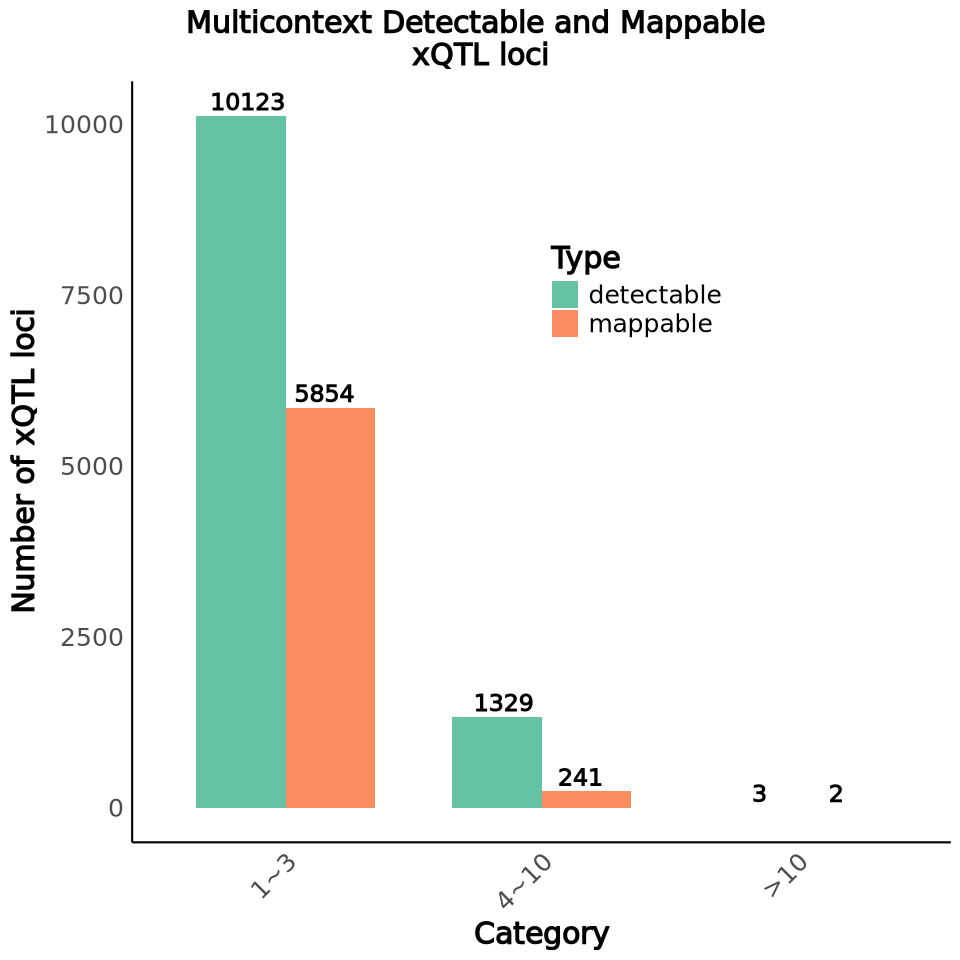

In [21]:
options(repr.plot.width = 8, repr.plot.height = 8)
p1

## multi-context fine-mapping vs single-context fine-mapping

### multi-context fine-mapping detectable and mappable

In [31]:
# summarize the multi-context detectable and mapping results
multicontext_top_loci_integrated <- ROSMAP_multicontext_top_loci_pip_sum %>%
  separate_rows(event_ID, conditional_effect, lfsr, sep = ";")%>%
  mutate(
    effect_sign = case_when(
      conditional_effect > 0 ~ "+1",
      conditional_effect < 0 ~ "-1",
      conditional_effect == 0 ~ "0",
      TRUE ~ NA_character_  # handle any unexpected NAs
    )
  )
coverage <- "cs_coverage_0.95"
multicontext_top_loci_integrated_detectable_mappable_pip_sum_95 <- multicontext_top_loci_integrated %>%
                                                            group_by(gene_ID)%>% filter(pip_sum >=0.95) %>% ungroup()%>%
                                                            group_by(event_ID, gene_ID)%>%
                                                            mutate(event_ID_n_detectable = ifelse(all(.data[[coverage]] == 0), 0, n_distinct(.data[[coverage]][.data[[coverage]] != 0])))%>%
                                                            group_by(event_ID, gene_ID, .data[[coverage]])%>%
                                                            mutate(variants_count = n())%>%
                                                            left_join(
                                                                    multicontext_top_loci_integrated %>%
                                                                    group_by(event_ID, gene_ID, .data[[coverage]]) %>%
                                                                    summarize(event_ID_detectable_variant_count = n(), .groups = "drop") %>%
                                                                    group_by(event_ID,gene_ID) %>%
                                                                    summarize(event_ID_n_mappable = sum(event_ID_detectable_variant_count <= 3),.groups = "drop"),
                                                                    by = c("gene_ID","event_ID")
                                                                   )
multicontext_detectable_sum <- multicontext_top_loci_integrated_detectable_mappable_pip_sum_95%>%
                                            filter(event_ID!="")%>%
                                            group_by(event_ID)%>%
                                            select(event_ID,gene_ID,event_ID_n_detectable)%>%
                                            ungroup()%>%
                                            unique()%>%
                                            group_by(event_ID)%>%
                                            mutate(event_ID_n_detectable_sum = sum(event_ID_n_detectable))%>%
                                            select(event_ID, event_ID_n_detectable_sum)%>%unique()%>%rename(resource = event_ID)
multicontext_mappable_sum <- multicontext_top_loci_integrated_detectable_mappable_pip_sum_95%>%
                                            filter(event_ID!="")%>%
                                            group_by(event_ID)%>%
                                            select(event_ID,gene_ID,event_ID_n_mappable)%>%
                                            ungroup()%>%
                                            unique()%>%
                                            group_by(event_ID)%>%
                                            mutate(event_ID_n_mappable_sum = sum(event_ID_n_mappable))%>%
                                            select(event_ID, event_ID_n_mappable_sum)%>%unique()%>%rename(context = event_ID)

In [33]:
# summarize the single-context detectable and mapping results
singlecontext_top_loci_integrated_detectable_mappable <- readRDS("~/project/Figure_2b/single_context_top_loci_integrated.rds")
singlecontext_detectable_sum <- singlecontext_top_loci_integrated_detectable_mappable %>% 
                                    filter(gene_ID%in%multicontext_top_loci_integrated$gene_ID)%>%
                                    filter(resource%in%unique(multicontext_top_loci_integrated$event_ID)[-1]) %>% 
                                    group_by(resource,gene_ID)%>%
                                    select(resource, gene_ID, event_ID_n_detectable)%>%
                                    ungroup()%>%
                                    unique()%>%
                                    group_by(resource)%>%
                                    mutate(event_ID_n_detectable_sum = sum(event_ID_n_detectable))%>%
                                    select(resource, event_ID_n_detectable_sum)%>%
                                    unique()
singlecontext_mappable_sum <- singlecontext_top_loci_integrated_detectable_mappable %>%
                                    filter(gene_ID%in%multicontext_top_loci_integrated$gene_ID)%>%
                                    filter(resource%in%unique(multicontext_top_loci_integrated$event_ID)[-1]) %>%
                                    group_by(resource,gene_ID)%>%
                                    select(resource, gene_ID, event_ID_n_mappable)%>%
                                    ungroup()%>%
                                    unique()%>%
                                    group_by(resource)%>%
                                    mutate(event_ID_n_mappable_sum = sum(event_ID_n_mappable))%>%
                                    select(resource, event_ID_n_mappable_sum)%>%
                                    unique()%>%rename(context=resource)

#### detectable comparison

In [37]:
multi_uni_detectable_compare <- multicontext_detectable_sum %>%
  left_join(singlecontext_detectable_sum, by = "resource") %>%
  # Optionally rename and select specific columns to tidy up the result
  select(resource, everything())%>%rename(context = resource, multi_detectable_sum = event_ID_n_detectable_sum.x, uni_detectable_sum = event_ID_n_detectable_sum.y)
multi_uni_detectable_compare

context,multi_detectable_sum,uni_detectable_sum
<chr>,<dbl>,<dbl>
AC_DeJager_eQTL,16739,9964
DLPFC_DeJager_eQTL,17122,9027
PCC_DeJager_eQTL,15989,6600
Exc_DeJager_eQTL,10244,5840
Inh_DeJager_eQTL,7018,2767
Oli_DeJager_eQTL,5528,2367
Ast_DeJager_eQTL,6335,2275
DLPFC_Bennett_pQTL,4324,3018
monocyte_ROSMAP_eQTL,1955,1600


In [38]:
library(RColorBrewer)
# Convert 'context' into a numeric factor for continuous coloring
p2 <- ggplot(multi_uni_detectable_compare, aes(x = uni_detectable_sum, y = multi_detectable_sum, color = context)) +
  geom_point(size = 5) +  # Size adjusted for visibility
  geom_text(aes(label = context), vjust = 1.2, hjust = -0.1,size = 8) +
  #scale_color_brewer(palette = "Set2") + 
  scale_x_continuous(limits = c(0, 18000)) +  # Adjust according to your data
  scale_y_continuous(limits = c(0, 18000)) +# Labels with slight horizontal adjustment 
  labs(
    x = "Single-context fine-mapping detectable loci",
    y = "Multi-context fine-mapping detectable loci"  # Legend title for color
  ) +
  ggtitle("Detectable xQTL loci comparison \n single-context vs multi-context") +
  theme_minimal() +
  theme(
    axis.line = element_line(color = "black",linewidth = 1),
    text = element_text(size = 18),
    plot.title = element_text(size = 25, face = "bold",hjust = 0.5),
    legend.position = "none",# Adjust legend position
    axis.title.x = element_text(size = 25, face = "bold"),
    axis.title.y = element_text(size = 25, face = "bold"),
      axis.text.x = element_text(size = 20),
  axis.text.y = element_text(size = 20),
    panel.grid = element_blank()
  ) +
   guides(
    color = guide_legend(override.aes = list(alpha = 1)),  # Ensure alpha is 1 (no transparency)
    shape = "none"  # Remove shape guide from the legend
  )+ 
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black",linewidth = 1.2)

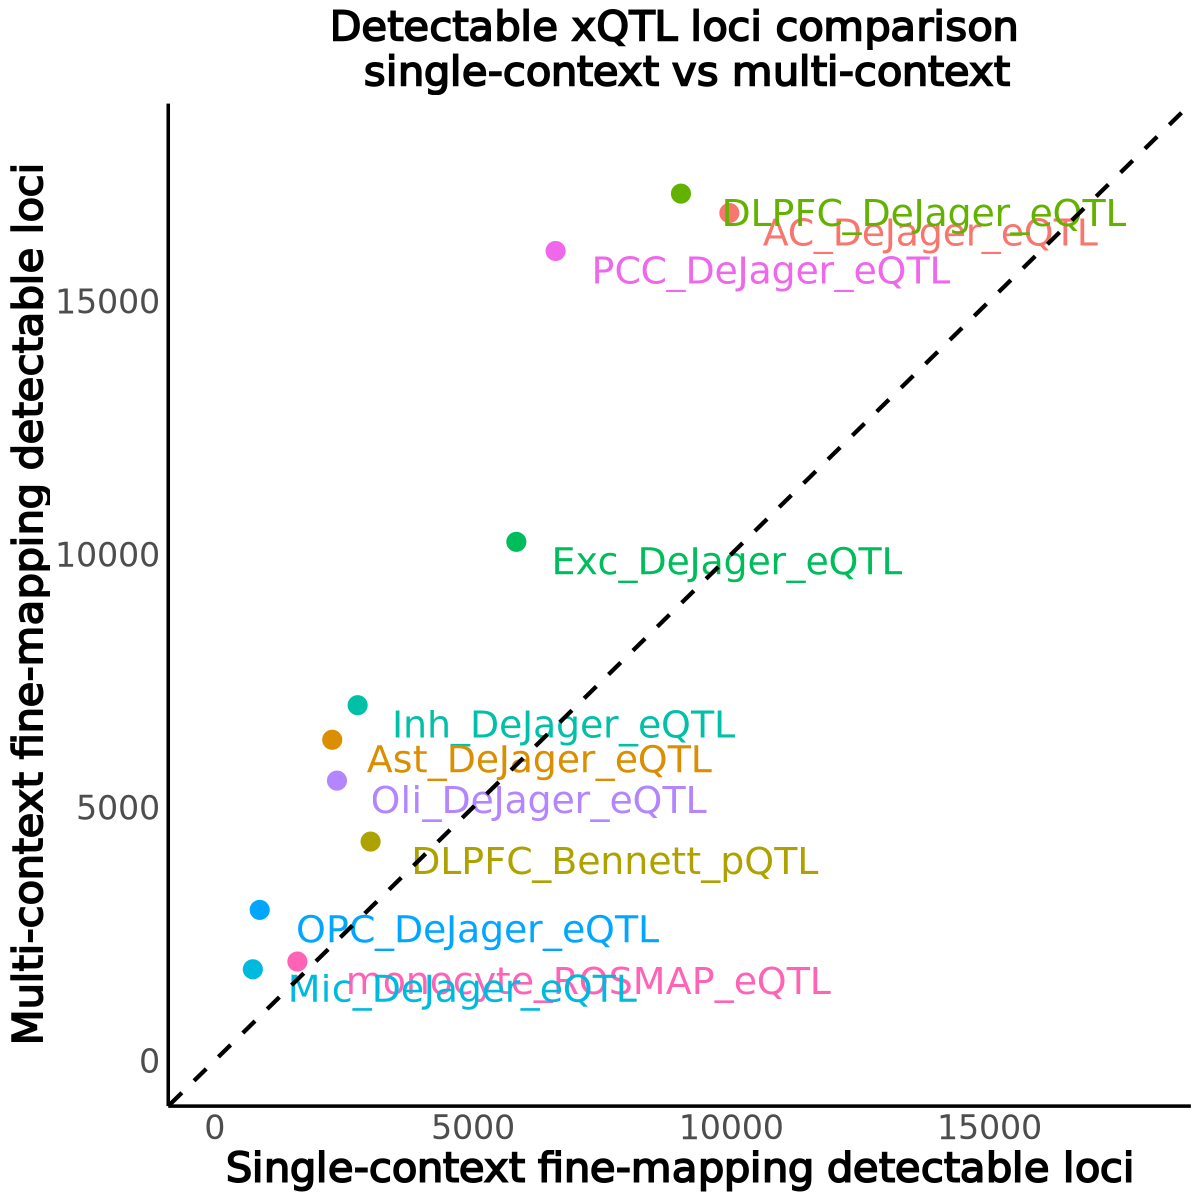

In [41]:
options(repr.plot.width = 10, repr.plot.height = 10)
p2

#### mappable comparison

In [42]:
multi_uni_mappable_compare <- multicontext_mappable_sum %>%
  left_join(singlecontext_mappable_sum, by = "context") %>%
  # Optionally rename and select specific columns to tidy up the result
  select(context, everything())%>%rename(multi_mappable_sum = event_ID_n_mappable_sum.x, uni_mappable_sum = event_ID_n_mappable_sum.y)
multi_uni_mappable_compare

context,multi_mappable_sum,uni_mappable_sum
<chr>,<int>,<dbl>
AC_DeJager_eQTL,6904,3662
DLPFC_DeJager_eQTL,7144,3436
PCC_DeJager_eQTL,6697,2289
Exc_DeJager_eQTL,3799,1769
Inh_DeJager_eQTL,2621,792
Oli_DeJager_eQTL,2071,767
Ast_DeJager_eQTL,2383,669
DLPFC_Bennett_pQTL,2159,1624
monocyte_ROSMAP_eQTL,755,725


In [44]:
library(ggplot2)
library(RColorBrewer)
p3 <- ggplot(multi_uni_mappable_compare, aes(x = uni_mappable_sum, y = multi_mappable_sum, color = context)) +
  geom_point(size = 5) +  # Size adjusted for visibility
  geom_text(aes(label = context), vjust = 1.5, hjust = -0.1,size = 8) +
  scale_x_continuous(limits = c(0, 7200)) +  # Adjust according to your data
  scale_y_continuous(limits = c(0, 7200)) +# Labels with slight horizontal adjustment 
  labs(
    x = "Single-context fine-mapping mappable loci",
    y = "Multi-context fine-mapping mappable loci"  # Legend title for color
  ) +
  ggtitle("Mappable loci comparison \nsingle context vs multi-context") +
  theme_minimal() +
  theme(
    axis.line = element_line(color = "black",linewidth = 1),
    text = element_text(size = 18),
    plot.title = element_text(size = 25, face = "bold",hjust = 0.5),
    legend.position = "none",# Adjust legend position
    axis.title.x = element_text(size = 25, face = "bold"),
    axis.title.y = element_text(size = 25, face = "bold"),
      axis.text.x = element_text(size = 20),
  axis.text.y = element_text(size = 20),
    panel.grid = element_blank()
  ) +
   guides(
    color = guide_legend(override.aes = list(alpha = 1)),  # Ensure alpha is 1 (no transparency)
    shape = "none"  # Remove shape guide from the legend
  )+ 
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black",linewidth = 1.2)

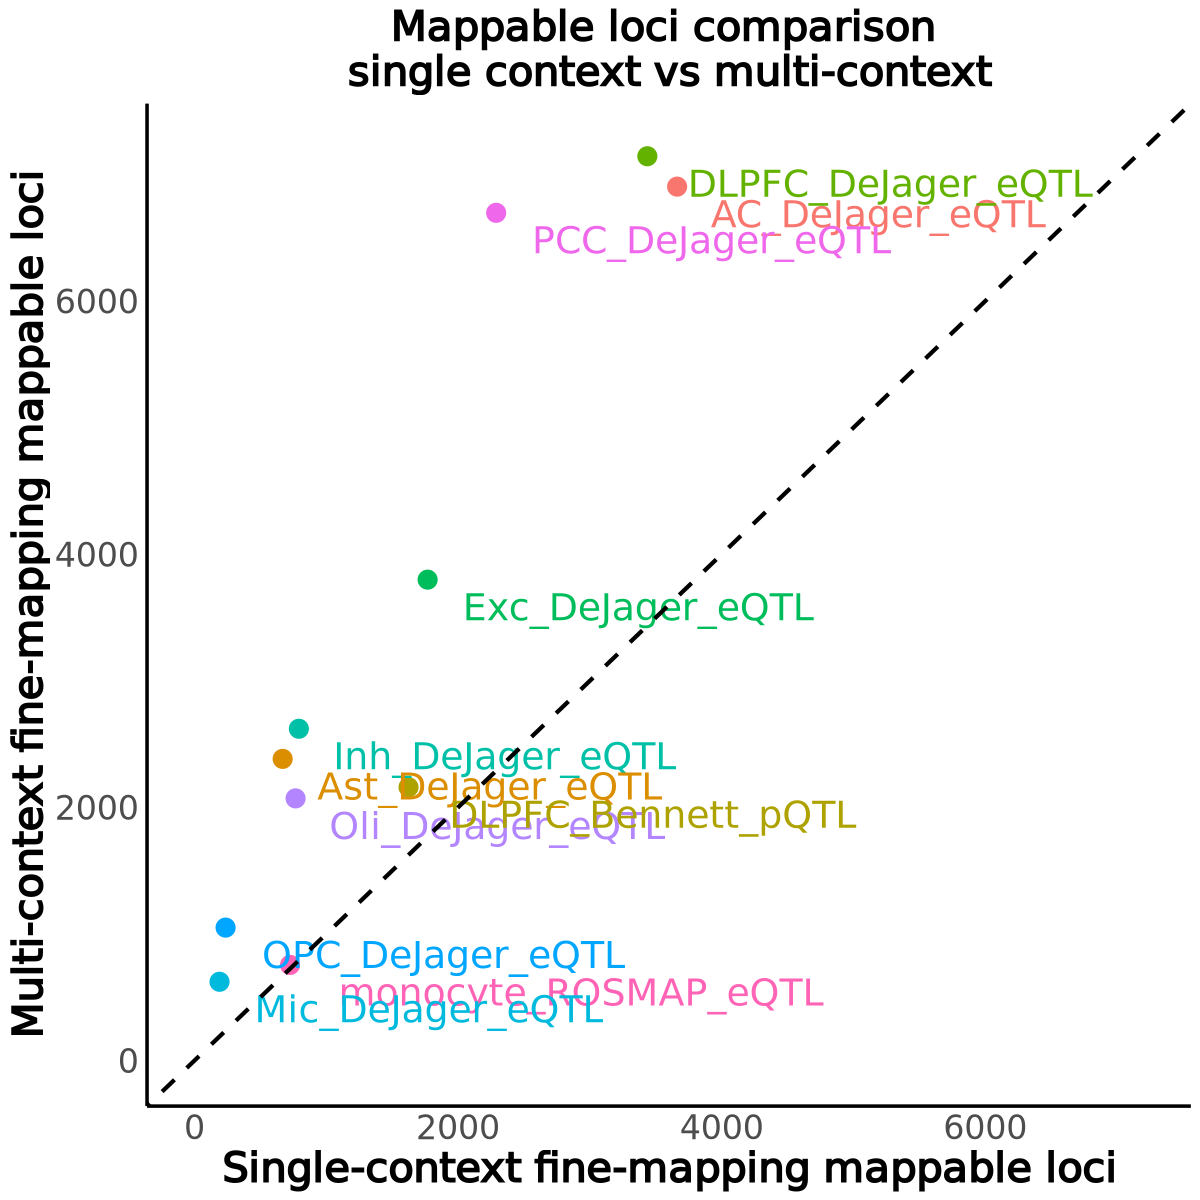

In [45]:
options(repr.plot.width = 10, repr.plot.height = 10)
p3